Dataset Link: https://www.kaggle.com/datasets/tejasurya/eng-spanish

In [ ]:
SEED = 6845
VOCAB_SIZE = 15000
BATCH_SIZE = 512

In [ ]:
import numpy as np
import tensorflow.keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
import random as r
import re
import string
r.seed(SEED)

# Data Preperation

In [ ]:
!ls

archive.zip  eng_spa_rnn2_temp.keras  sample_data  spa-eng  spa.txt


In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace spa-eng/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spa-eng/_about.txt      
replace spa-eng/spa.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spa.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
with open('spa.txt') as f:
  rows = f.readlines()
rows[0:10]

['Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)\n',
 'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)\n',
 'Go.\tVaya.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)\n',
 'Go.\tVáyase.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)\n',
 'Hi.\tHola.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)\n',
 'Hi.\tHola\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #10908352 (TeacherGeorge123)\n',
 'Run!\t¡Corre!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)\n',
 'Run!\t¡Corran!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)\n',
 'Run!\t¡Corra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)\n',
 'Run!\t¡Corred!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #80056

In [ ]:
pairs = []
for row in rows:
  tmp = row.split('\t')
  pairs.append(
      (tmp[0], '[start] %s [end]'%tmp[1])
      )
pairs[:10]

[('Go.', '[start] Ve. [end]'),
 ('Go.', '[start] Vete. [end]'),
 ('Go.', '[start] Vaya. [end]'),
 ('Go.', '[start] Váyase. [end]'),
 ('Hi.', '[start] Hola. [end]'),
 ('Hi.', '[start] Hola [end]'),
 ('Run!', '[start] ¡Corre! [end]'),
 ('Run!', '[start] ¡Corran! [end]'),
 ('Run!', '[start] ¡Corra! [end]'),
 ('Run!', '[start] ¡Corred! [end]')]

In [ ]:
def train_test_val_split(pairs, val_percent, test_percent):
  r.shuffle(pairs)
  length = len(pairs)
  num_val = int(length*val_percent)
  num_test = int(length*test_percent)
  return pairs[num_val+num_test:], pairs[:num_test], pairs[num_test: num_val+num_test]

In [ ]:
train, test, val = train_test_val_split(pairs, 0.15, 0.15)

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
to_remove = string.punctuation+"¿"
to_remove = to_remove.replace('[','')
to_remove = to_remove.replace(']','')

def spanish_standardization(x):
  return tf.strings.regex_replace(
      tf.strings.lower(x),
      "[%s]"%re.escape(to_remove),
      ""
  )

en_vectorizer = k.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int'
    )
sp_vectorizer = k.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    standardize=spanish_standardization
    )

en_text = list(map(lambda x: x[0], train))
sp_text = list(map(lambda x: x[1], train))

en_vectorizer.adapt(en_text)
sp_vectorizer.adapt(sp_text)

In [ ]:
def format_dataset(en, sp):
  global en_vectorizer, sp_vectorizer
  en = en_vectorizer(en)
  sp = sp_vectorizer(sp)
  return (
      {
          "english": en,
          "spanish": sp[:, :-1]
      },
      sp[:, 1:]
  )

In [ ]:
def make_dataset(pairs):
  eng_texts, spa_texts = zip(*pairs)
  eng_texts = list(eng_texts)
  spa_texts = list(spa_texts)
  dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.map(format_dataset)
  return dataset.shuffle(SEED).prefetch(16).cache()

In [ ]:
train_ds = make_dataset(train)
val_ds = make_dataset(val)

In [ ]:
EMBED_DIM = 256
LATENT_DIM = 1024

encoder_input = k.Input(shape=(None,), dtype='int64', name='english')
x1 = k.layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(encoder_input)

decoder_input = k.Input(shape=(None,), dtype='int64', name='spanish')
x2 = k.layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(decoder_input)

encoder_bidirectional_gru = k.layers.Bidirectional(
    k.layers.GRU(LATENT_DIM),
    merge_mode = 'sum'
)(x1)

decoder_gru = k.layers.GRU(LATENT_DIM, return_sequences=True)(
    x2,
    initial_state = encoder_bidirectional_gru
    )
x3 = k.layers.Dropout(0.5)(decoder_gru)
target = k.layers.Dense(VOCAB_SIZE, activation='softmax')(x3)

seq2seq_rnn = k.Model(
    [encoder_input, decoder_input],
    target
)

In [36]:
seq2seq_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    3840000     ['english[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    3840000     ['spanish[0][0]']                
                                                                                              

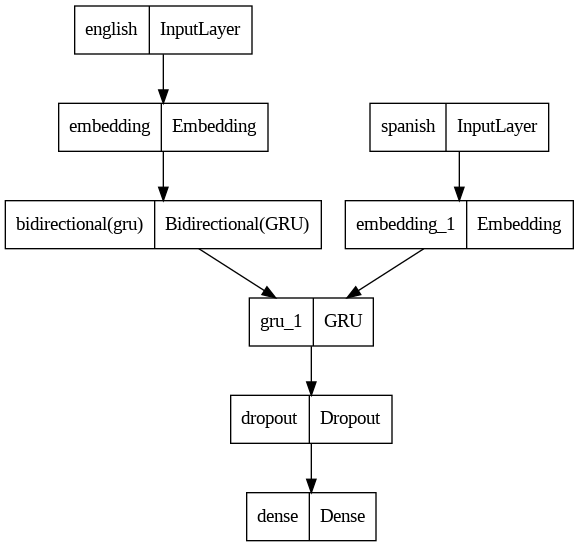

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(seq2seq_rnn)

In [ ]:
filename = "eng_spa_rnn2_temp.keras"
callbacks = [k.callbacks.ModelCheckpoint(filename,save_best_only=True)]
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
  metrics=["accuracy"]
)
seq2seq_rnn.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks)

Epoch 1/20
191/191 [==============================] - 122s 575ms/step - loss: 2.3511 - accuracy: 0.5448 - val_loss: 2.3912 - val_accuracy: 0.5549
Epoch 2/20
191/191 [==============================] - 96s 502ms/step - loss: 2.2523 - accuracy: 0.5576 - val_loss: 2.3127 - val_accuracy: 0.5686
Epoch 3/20
191/191 [==============================] - 98s 513ms/step - loss: 2.1714 - accuracy: 0.5678 - val_loss: 2.2604 - val_accuracy: 0.5738
Epoch 4/20
191/191 [==============================] - 95s 500ms/step - loss: 2.0805 - accuracy: 0.5796 - val_loss: 2.2051 - val_accuracy: 0.5832
Epoch 5/20
191/191 [==============================] - 95s 499ms/step - loss: 2.0033 - accuracy: 0.5901 - val_loss: 2.1450 - val_accuracy: 0.5916
Epoch 6/20
191/191 [==============================] - 95s 499ms/step - loss: 1.9309 - accuracy: 0.6000 - val_loss: 2.1101 - val_accuracy: 0.5977
Epoch 7/20
191/191 [==============================] - 95s 499ms/step - loss: 1.8599 - accuracy: 0.6096 - val_loss: 2.0616 - val_a

In [32]:
def decode_sequence(input_sentence, max_decoded_length=20):
  global en_vectorizer, sp_vectorizer
  input_tokens = en_vectorizer([input_sentence])
  decoded_sentence = "[start]"
  for i in range(max_decoded_length):
    target_tokens = sp_vectorizer([decoded_sentence])
    next_token = seq2seq_rnn.predict([input_tokens, target_tokens], verbose = 0)
    sampled_token_index = np.argmax(next_token[0, i, :])
    spa_vocab = sp_vectorizer.get_vocabulary()
    sampled_token = spa_vocab[sampled_token_index]
    decoded_sentence += " " + sampled_token
    if sampled_token == "[end]":
      break
  return decoded_sentence

In [33]:
decode_sequence('this is a book')

'[start] este es un libro [end]'

In [34]:
decode_sequence('hi! my name is Sam.')

'[start] desafortunadamente mi nombre es [UNK] [end]'

In [35]:
[(decode_sequence(x[0]), x[1]) for x in test[:10]]

[('[start] ella se [UNK] a la [UNK] en la espalda [end]',
  '[start] Ella se estiró para aliviar su rigidez de espalda. [end]'),
 ('[start] siempre he terminado de comida solo [end]',
  '[start] Siempre he preferido trabajar solo. [end]'),
 ('[start] todos mis sueños se hacen [end]',
  '[start] Toda mi tarea está hecha. [end]'),
 ('[start] tom no tuvo el valor para ir allí solo [end]',
  '[start] Tom no tuvo el valor para ir ahí por sí solo. [end]'),
 ('[start] tom nunca respondió [end]', '[start] Tom nunca escucha. [end]'),
 ('[start] por favor [UNK] la carta por favor [end]',
  '[start] Baja un poco la música por favor. [end]'),
 ('[start] ya te he olvidado de ti [end]', '[start] Ya te pagué. [end]'),
 ('[start] tom habló en un segundo [end]',
  '[start] Tom habló en sus sueños. [end]'),
 ('[start] podría salir a que te quedes [end]',
  '[start] Podría ordenarte que te quedes. [end]'),
 ('[start] el marido de tom es rico [end]',
  '[start] El esposo de Mary es rico. [end]')]


The results from google tranlate
```
[('[start] she will [UNK] to the [UNK] on the back [end]',
   '[start] She stretched to ease the stiffness in her back. [end]'),
  ('[start] I've always finished food by myself [end]',
   '[start] I have always preferred to work alone. [end]'),
  ('[start] all my dreams come true [end]',
   '[start] All my homework is done. [end]'),
  ('[start] tom didn't have the courage to go there by himself [end]',
   '[start] Tom didn't have the courage to go there by himself. [end]'),
  ('[start] tom never answered [end]', '[start] Tom never listens. [end]'),
  ('[start] please [UNK] the letter please [end]',
   '[start] Turn the music down a bit please. [end]'),
  ('[start] I already forgot about you [end]', '[start] I already paid you. [end]'),
  ('[start] tom spoke in a second [end]',
   '[start] Tom spoke in his sleep. [end]'),
  ('[start] could leave for you to stay [end]',
   '[start] I could order you to stay. [end]'),
  ('[start] tom's husband is rich [end]',
   '[start] Mary's husband is rich. [end]')]
   ```